In [1]:
import torch

from survae import SurVAE
from survae.data import ngon, Dataset, moons, spiral, split_line
from survae.layer import BijectiveLayer, AbsoluteUnit, OrthonormalLayer, Augment
from survae.plot import plot_models, plot_losses
from survae.train import train_models

In [2]:
model_generators = [
    lambda: SurVAE(
        [
            BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
            BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
            BijectiveLayer(2, [64] * 5), OrthonormalLayer(2),
            BijectiveLayer(2, [64] * 5),
        ],
        name="NF",
    ),
    lambda: SurVAE(
        [
            Augment(2, 4),
            BijectiveLayer(4, [64] * 5), OrthonormalLayer(4),
            BijectiveLayer(4, [64] * 5), OrthonormalLayer(4),
            BijectiveLayer(4, [64] * 5), OrthonormalLayer(4),
            BijectiveLayer(4, [64] * 5),
        ],
        name="NF-augmented",
    ),
    lambda: SurVAE(
        [
            Augment(2, 4),
            BijectiveLayer(4, [64] * 5), OrthonormalLayer(4),
            BijectiveLayer(4, [64] * 5),
            AbsoluteUnit(torch.tensor([0.5] * 4)),
            BijectiveLayer(4, [64] * 5), OrthonormalLayer(4),
            BijectiveLayer(4, [64] * 5),
        ],
        name="NF-augmented-abs",
    ),
]

In [3]:
datasets = [
    Dataset(moons, name="Moons"),
    Dataset(spiral, name="Spiral"),
    Dataset(ngon, name="N-gon"),
    Dataset(split_line, name="Split Line"),
]

In [4]:
models = train_models(model_generators, datasets, epochs=10_000)

 75%|███████▌  | 9/12 [00:21<00:06,  2.27s/it]/home/xiaoxiae/Documents/Education/School/Heidelberg/Studium/Magisterské/3. semestr/Generative Neural Networks for the Sciences (ML)/final/survae/data.py:289: RuntimeWarning: covariance is not positive-semidefinite.
  data = np.random.multivariate_normal(mu, sigma, n)
100%|██████████| 12/12 [00:26<00:00,  2.22s/it]


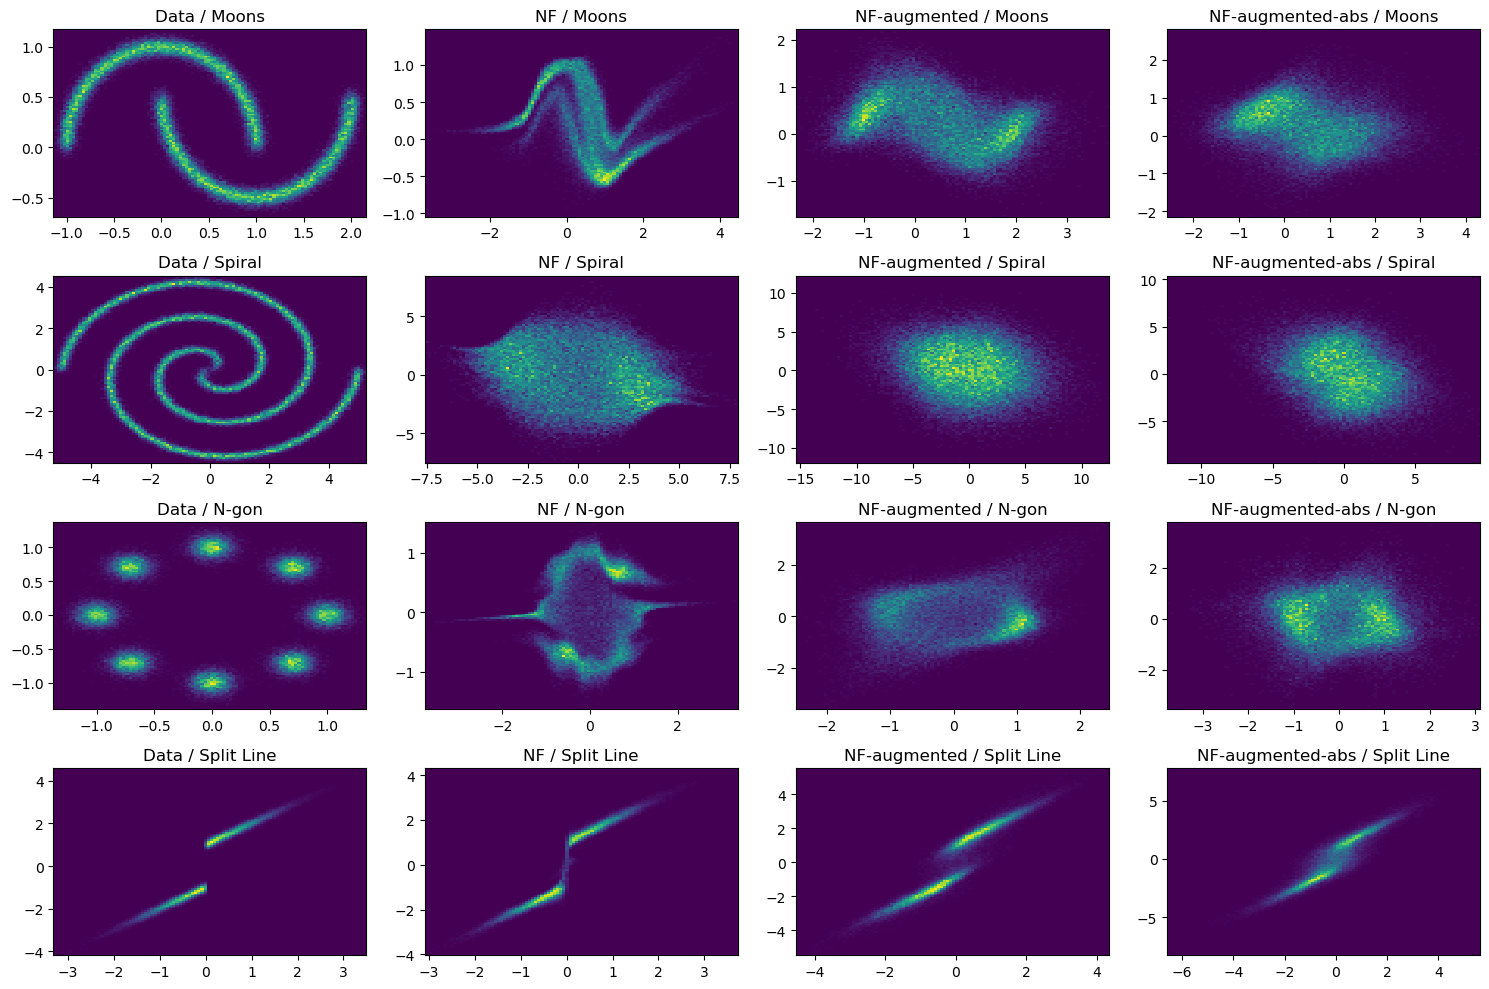

In [5]:
plot_models(models, datasets)

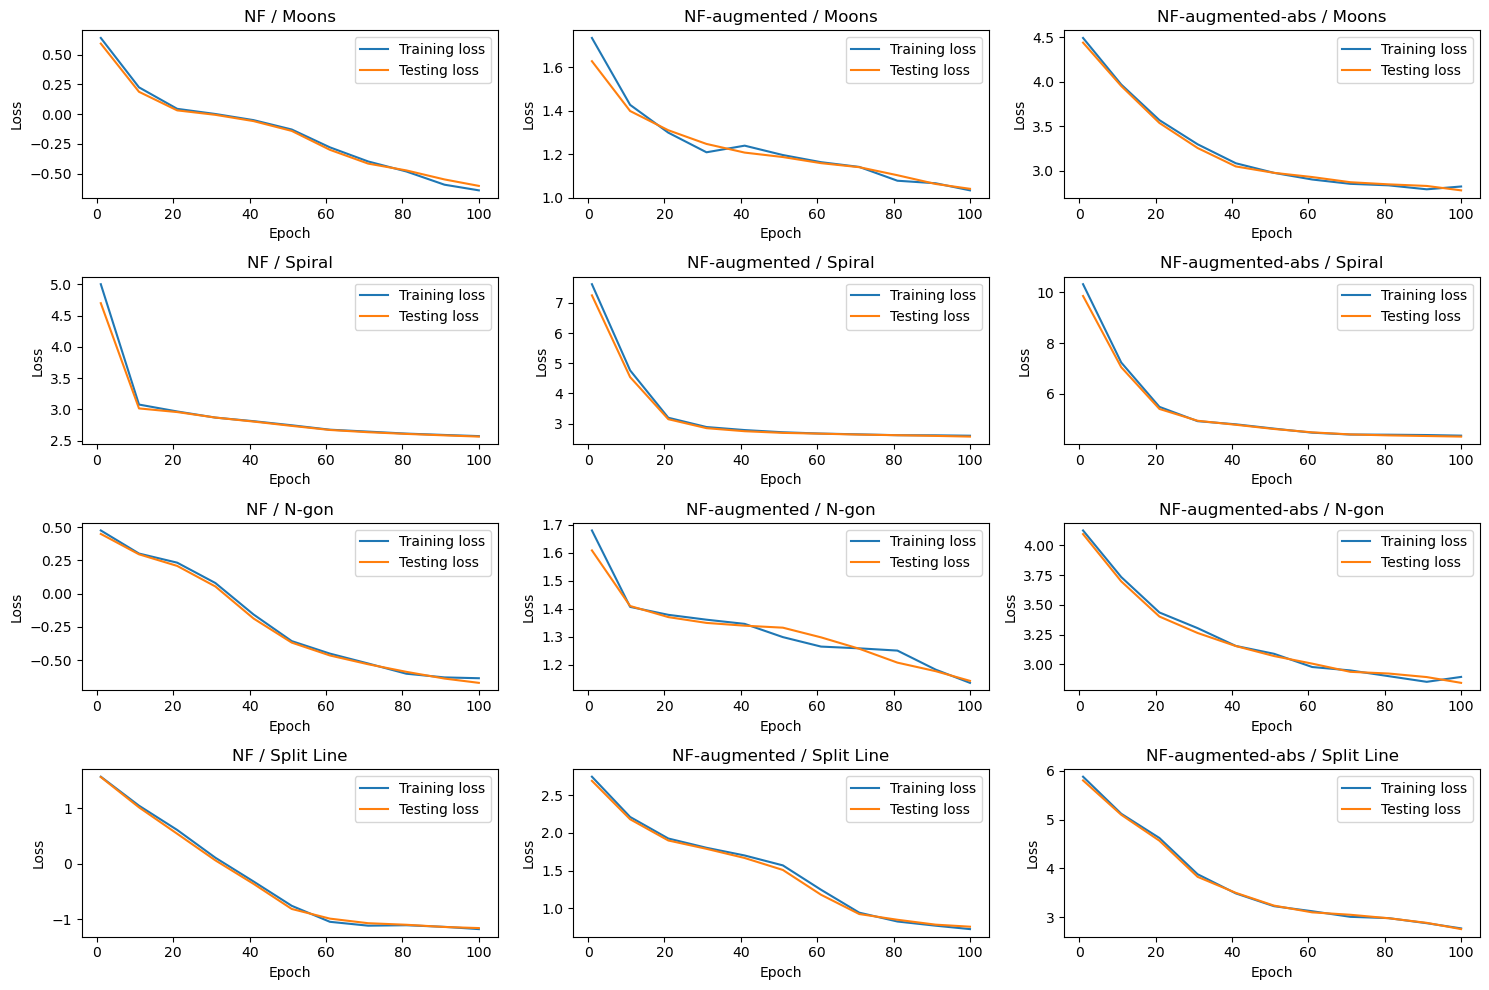

In [6]:
plot_losses(models, datasets)